# Question 1

## Part b

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('rldata_cw.csv', index_col=0)
df

,stage,state,action,reward
0,0,20,4,0.894561
1,1,26,3,0.969770
2,2,26,4,0.621957
3,3,3,0,0.574317
4,4,14,0,1.186185
...,...,...,...,...
49995,0,20,3,-0.055884
49996,1,12,3,0.322217
49997,2,0,3,0.150933
49998,3,25,3,0.910205


In [3]:
# significance level
alpha = 0.05

In [4]:
# get the number of states and actions
num_states = df['state'].nunique()
num_actions = df['action'].nunique()

In [5]:
# Bonferroni-corrected significance level
bonferroni_alpha = alpha / (num_actions * num_states * (num_states - 1) // 2)
bonferroni_alpha

2.2988505747126437e-05

In [6]:
# perform the hypothesis tests for each pair of states and each action
p_values = {}
for i in range(num_states):
    for j in range(i + 1, num_states):
        state_i = f"x{i}"
        state_j = f"x{j}"
        p_values[(state_i, state_j)] = {}
        for action in range(num_actions):
            rewards_i = df[(df["state"] == i) & (df["action"] == action)]["reward"]
            rewards_j = df[(df["state"] == j) & (df["action"] == action)]["reward"]
            _, p_value = ttest_ind(rewards_i, rewards_j, equal_var=True)
            p_values[(state_i, state_j)][f"a{action}"] = p_value


In [7]:
# find equivalent states
equivalent_states = []
for i in range(num_states):
    state_i = f"x{i}"
    equivalent_group = [state_i]
    for j in range(i + 1, num_states):
        state_j = f"x{j}"
        if all(
            p_values[(state_i, state_j)][f"a{action}"] > bonferroni_alpha
            for action in range(num_actions)
        ):
            equivalent_group.append(state_j)
    equivalent_states.append(tuple(equivalent_group))

In [8]:
# print the equivalent states
checklist_elements = set()
print("Equivalent states:")
for group in equivalent_states:
    if not (set(group) & checklist_elements) and (len(group) > 1):
        print(group)
        checklist_elements.update(group)

Equivalent states:
('x0', 'x2', 'x6', 'x12', 'x16', 'x20', 'x25')
('x1', 'x26')
('x3', 'x5', 'x9')
('x4', 'x27')
('x7', 'x11', 'x13', 'x15', 'x18', 'x23')
('x8', 'x10', 'x24')
('x14', 'x19', 'x21', 'x28', 'x29')
('x17', 'x22')


In [9]:
# Define the mapping of old states to new states
state_mapping = {
    0: 0, 2: 0, 6: 0, 12: 0, 16: 0, 20: 0, 25: 0,
    1: 1, 26: 1,
    3: 2, 5: 2, 9: 2,
    4: 3, 27: 3,
    7: 4, 11: 4, 13: 4, 15: 4, 18: 4, 23: 4,
    8: 5, 10: 5, 24: 5,
    14: 6, 19: 6, 21: 6, 28: 6, 29: 6,
    17: 7, 22: 7
}

# Re-label the states in the dataset
df['state'] = df['state'].map(state_mapping)
df

,stage,state,action,reward
0,0,0,4,0.894561
1,1,1,3,0.969770
2,2,1,4,0.621957
3,3,2,0,0.574317
4,4,6,0,1.186185
...,...,...,...,...
49995,0,0,3,-0.055884
49996,1,0,3,0.322217
49997,2,0,3,0.150933
49998,3,0,3,0.910205


## Part f

In [10]:
df["next_state"] = df["state"].shift(-1)
df.loc[df["stage"] == 4, "next_state"] = None
df

,stage,state,action,reward,next_state
0,0,0,4,0.894561,1.0
1,1,1,3,0.969770,1.0
2,2,1,4,0.621957,2.0
3,3,2,0,0.574317,6.0
4,4,6,0,1.186185,NaN
...,...,...,...,...,...
49995,0,0,3,-0.055884,0.0
49996,1,0,3,0.322217,0.0
49997,2,0,3,0.150933,0.0
49998,3,0,3,0.910205,0.0


In [11]:
# Get the number of states and actions
S = df['state'].nunique() # 8
A = df['action'].nunique() # 5
H = df["stage"].nunique() # 5

In [12]:
# Estimate the expected rewards, state-action pairs, MLE -> sample mean
expected_rewards = np.zeros((S, A))
for s in range(S):
    for a in range(A):
        filter_rewards = (df['state'] == s) & (df['action'] == a)
        rewards = df[filter_rewards]['reward']
        df.loc[filter_rewards, "mean_reward"] = rewards.mean()
        expected_rewards[s, a] = rewards.mean()
expected_rewards.shape

(8, 5)

In [13]:
# Estimate the transition probabilities
transition_probs = np.zeros((S, A, S))
for s in range(S):
    for a in range(A):
        next_states = df[(df['state'] == s) & (df['action'] == a) & (df["next_state"].notna())]
        next_states = next_states["next_state"]
        for next_s in next_states:
            transition_probs[s, a, int(next_s)] += 1
        transition_probs[s, a] /= transition_probs[s, a].sum()
transition_probs.shape

(8, 5, 8)

In [14]:
# Value iteration
V = np.zeros((H + 1, S)) 
Q = np.zeros((H, S, A))

for h in range(H-1, -1, -1):
    for s in range(S):
        for a in range(A):
            Q[h, s, a] = expected_rewards[s, a] + np.dot(transition_probs[s, a, :], V[h + 1])
    V[h] = np.max(Q[h], axis=1)

# Extract the optimal policy for each stage
optimal_policies = np.argmax(Q, axis=2)

print("Optimal policies for each stage (starting from stage 0):")
print(optimal_policies)

Optimal policies for each stage (starting from stage 0):
[[2 4 3 3 4 4 3 1]
 [2 4 1 3 4 4 3 1]
 [2 4 1 3 4 4 3 1]
 [2 4 4 3 4 4 0 1]
 [2 4 4 3 1 3 0 1]]


In [15]:
V

array([[4.36086974, 4.01280299, 3.47330539, 4.11012781, 4.03035965,
        3.68149085, 3.88807076, 3.96023602],
       [3.57232188, 3.22545893, 2.68479481, 3.32090052, 3.24594203,
        2.88847105, 3.09601959, 3.17007066],
       [2.76894506, 2.44581868, 1.91391975, 2.53614304, 2.45730711,
        2.09108769, 2.28841299, 2.38853181],
       [1.93042348, 1.65824619, 1.24813095, 1.74636025, 1.65649617,
        1.29431259, 1.49140329, 1.60962009],
       [0.99743554, 0.86231987, 0.62406548, 0.94427893, 0.84845437,
        0.48804111, 0.75030793, 0.81956994],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

## Part g

In [16]:
trajectory_counter = 0
for iteration, row in df.iterrows():
    if iteration % 5 == 0:
        trajectory_counter += 1
    df.loc[df.index == iteration, "trajectory"] = trajectory_counter
df

,stage,state,action,reward,next_state,mean_reward,trajectory
0,0,0,4,0.894561,1.0,0.607413,1.0
1,1,1,3,0.969770,1.0,0.402870,1.0
2,2,1,4,0.621957,2.0,0.862320,1.0
3,3,2,0,0.574317,6.0,0.315934,1.0
4,4,6,0,1.186185,NaN,0.750308,1.0
...,...,...,...,...,...,...,...
49995,0,0,3,-0.055884,0.0,0.521748,10000.0
49996,1,0,3,0.322217,0.0,0.521748,10000.0
49997,2,0,3,0.150933,0.0,0.521748,10000.0
49998,3,0,3,0.910205,0.0,0.521748,10000.0


In [17]:
# importance sampling algorithm, with data, data generating policy, new policy,
def ImportanceSampling(df, dataPol, myPol, H, S, A):
    T = int(df.shape[0] / H)  # calculate number of episodes
    Vsum = np.zeros(S)
    # K = np.zeros(S)  # count the number of trajectories that start with state i
    Wsum = np.zeros(S)
    # go through all episodes
    for t in range(T):
        s = df.state[H * t]  # check initial state of the trajectory
        # K[s] += 1.0  # add to counter

        # calculate importance sampling ratio and G
        is_ratio = 1.0
        G = 0.0
        for h in range(H):
            state = int(df.iloc[H * t + h]["state"])
            action = int(df.iloc[H * t + h]["action"])
            reward = df.iloc[H * t + h]["reward"]

            is_ratio *= myPol[h, state, action] / dataPol[h, state, action]
            G += reward

        Vsum[s] += G * is_ratio
        Wsum[s] += is_ratio

    Wsum = [x if x != 0 else 1 for x in Wsum]
    # Vhat = Vsum / K
    Vhat = Vsum / Wsum
    
    return Vhat

In [18]:
# Initialize myPol as a 3D array with all zeros
myPol = np.zeros((H, S, A))

# Set the probability of the optimal action to 1 for each state at each stage
for h in range(H):
    for s in range(S):
        optimal_action = optimal_policies[h, s]
        myPol[h, s, optimal_action] = 1.0
myPol.shape

(5, 8, 5)

In [19]:
dataPol = np.ones((H, S, A)) / A
dataPol.shape

(5, 8, 5)

In [20]:
ImportanceSampling(df, dataPol, myPol, H, S, A)

array([4.80519992, 4.23072052, 4.67630493, 0.        , 3.35996951,
       4.13995897, 0.        , 0.        ])

## Part h

In [21]:
total_rewards = df.groupby('trajectory')['reward'].sum()
total_rewards

trajectory
1.0        4.246789
2.0        3.030061
3.0        2.536154
4.0        2.516328
5.0        3.382050
             ...   
9996.0     3.893679
9997.0     1.043087
9998.0     3.402186
9999.0     1.830671
10000.0    2.388447
Name: reward, Length: 10000, dtype: float64

In [22]:
v_avg = total_rewards.mean()
v_avg

2.4689923229239747

In [23]:
res = ImportanceSampling(df, dataPol, dataPol, H,S, A)
res

array([2.54279302, 2.40872414, 2.27768351, 2.5559339 , 2.64523843,
       2.27385248, 2.36718753, 2.46867411])

In [24]:
np.mean(res)

2.442510888588008

# Question 2

## Part d

In [25]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, WhiteKernel, ExpSineSquared

In [26]:
%run GP_Setup.ipynb

In [27]:
# np.random.seed(6592)
np.random.seed(132)

In [28]:
class LinearUCB:
    def __init__(self, x, T, d, alpha):
        self.x = x
        self.T = T
        self.d = d  # Dimension of the feature vector
        self.A = np.eye(d)  
        self.b = np.zeros((d, 1))  # Initialize the bias vector
        self.alpha = alpha  # Exploration parameter

    def update(self, x, y):
        x = x.reshape(-1, 1)
        self.A += np.dot(x, x.T)
        self.b += y * x

    def recommend(self):
        inv_A = np.linalg.inv(self.A)
        theta = np.dot(inv_A, self.b)
        ucb_scores = np.zeros(len(self.x))
        for i in range(len(self.x)):
            x = self.x[i].reshape(-1, 1)
            ucb_scores[i] = theta.T @ x + self.alpha * np.sqrt(x.T @ inv_A @ x)
            # UCB score = theta^T * x + alpha * sqrt(x^T * A^(-1) * x)
        
        # Select the action with the highest UCB score
        best_action = np.argmax(ucb_scores)
        return self.x[best_action]

In [29]:
class GPTS:
    def __init__(self, env, x, T, kernel):
        self.x = x
        self.T = T
        self.env = env
        if kernel == "linear":
            kernel = C(1.0) * DotProduct() + WhiteKernel()
        elif kernel == "sinus":
            # kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
            kernel = C(1.0) * RBF(1.0) + ExpSineSquared(length_scale=1.0, periodicity=2*np.pi)
        elif kernel == "poly":
            # kernel = DotProduct(sigma_0=1) + WhiteKernel()
            kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)

        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=1, random_state=0)
    
    def update(self):
        # Fit GP to all observed data
        return self.gp.fit(self.env.xhist.reshape(-1, 1), self.env.yhist)
        # return self.gp

In [30]:
class GPUCB:
    def __init__(self, env, x, T, kernel=None):
        self.x = x
        self.T = T
        self.env = env
        if kernel is None:
            kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=1, random_state=0)
    
    def update(self):
        self.gp.fit(self.env.xhist.reshape(-1, 1), self.env.yhist)
    
    def recommend(self):
        def ucb(x):
            x = np.array([[x]]).reshape(-1, 1)
            mu, sigma = self.gp.predict(x, return_std=True)
            beta = np.sqrt(2*np.log(np.pi**2*(self.env.xmax-self.env.xmin)*self.T*len(self.env.yhist)**2/6))
            
            return -(mu + beta * sigma)  # Maximize UCB

        return fminbound(ucb, self.env.xmin, self.env.xmax) # x_opt

In [31]:
def linear_function(x):
    return 3 * x + 1

In [32]:
def qudratic_function(x):
    return (x - 4)**2 - 3

In [33]:
def sinusoidal_function(x):
    return x * np.sin(x)

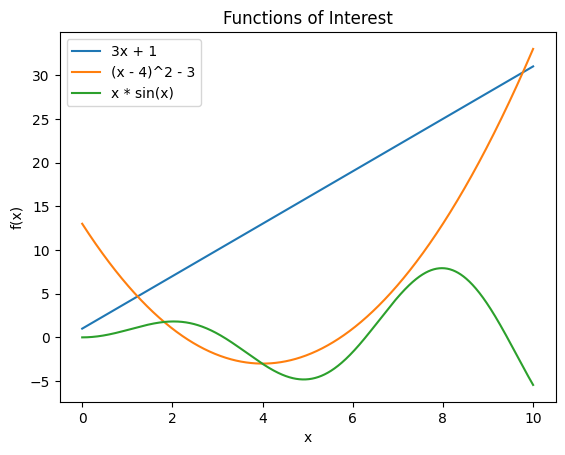

In [34]:
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
plt.plot(X, linear_function(X), label="3x + 1")
plt.plot(X, qudratic_function(X), label="(x - 4)^2 - 3")
plt.plot(X, sinusoidal_function(X), label="x * sin(x)")
plt.title("Functions of Interest")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [35]:
def run_gpucb(f, T: int = 30, xmin: float = 0, xmax: float = 10):
    env = GPEnv(xmin, xmax, f, noisevar=0.1)
    env.reset()

    x = np.random.uniform(xmin, xmax)
    y = env.play(x)

    rew = np.zeros(T) 
    reg = np.zeros(T) 
    rew[0] = y
    reg[0] = env.maxrew - env.f(x)

    model = GPUCB(env=env, T=T, x=x)
    for t in range(1, T):
        model.update()
        myx = model.recommend()
        y = env.play(myx)
        
        rew[t] = y
        reg[t] = env.maxrew - env.f(myx)
    
    return reg, model, env

In [36]:
def run_gpts(f, kernel, T: int = 30, xmin: float = 0, xmax: float = 10):
    thompson_env = GPEnv(xmin=xmin, xmax=xmax, f=f, noisevar=0.1)
    thompson_env.reset()

    x = np.random.uniform(xmin, xmax)
    y = thompson_env.play(x)

    ts_rew = np.zeros(T) 
    ts_reg = np.zeros(T) 
    ts_rew[0] = y
    ts_reg[0] = thompson_env.maxrew - thompson_env.f(x)

    #define set over which we search for the best action
    search_set = np.linspace(xmin, xmax, 1000)
    ts_model = GPTS(env=thompson_env, T=T, x=x, kernel=kernel)
    for t in range(1, T):
        gp = ts_model.update()
        #sample a function from the posterior, evaluate over search_set
        posterior_sample = gp.sample_y(search_set.reshape(-1, 1))[:,0]
        #play x with the largest function value
        myx_index = np.argmax(posterior_sample)
        myx = search_set[myx_index]
        y = thompson_env.play(myx)
        ts_rew[t] = y
        ts_reg[t] = thompson_env.maxrew - thompson_env.f(myx)
    
    return ts_reg, ts_model, thompson_env

In [37]:
def run_linucb(f, T: int = 30, xmin: float = 0, xmax: float = 10, alpha: float = 1.0, d: int = 1):
    env = GPEnv(xmin, xmax, f, noisevar=0.1)
    env.reset()

    x_pool = np.linspace(xmin, xmax, 100).reshape(-1, d) 
    model = LinearUCB(x=x_pool, T=T, d=d, alpha=alpha)

    rew = np.zeros(T) 
    reg = np.zeros(T)
    
    for t in range(T):
        action = model.recommend()
        y = env.play(action)
        model.update(action, y)
        rew[t] = y
        optimal_reward = f(env.argmax)  
        reg[t] = optimal_reward - y

    return np.cumsum(reg), model, env

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
gpucb_regs = []
gpts_regs = []
linucb_regs = []
for _ in tqdm(range(10)):
    gpucb_reg, gpucb_model, gpucb_env = run_gpucb(linear_function)
    gpucb_regs.append(np.cumsum(gpucb_reg))
    gpts_reg, gpts_model, gpts_env = run_gpts(linear_function, "linear")
    gpts_regs.append(np.cumsum(gpts_reg))
    linucb_reg, lin_model, lin_env = run_linucb(linear_function)
    linucb_regs.append(linucb_reg)

100%|██████████| 10/10 [02:57<00:00, 17.75s/it]


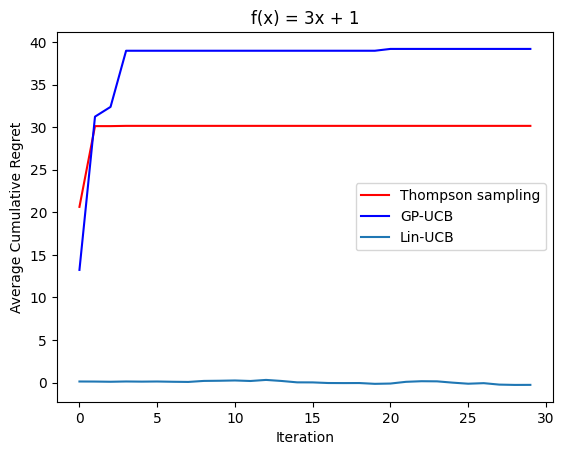

In [40]:
plt.plot(np.mean(gpts_regs, axis=0), label = 'Thompson sampling',color = 'r')
plt.plot(np.mean(gpucb_regs, axis=0), label = 'GP-UCB',color = 'b')
plt.plot(np.mean(linucb_regs, axis=0), label = 'Lin-UCB')
plt.xlabel('Iteration')
plt.ylabel('Average Cumulative Regret')
plt.title('f(x) = 3x + 1')
plt.legend()
plt.show()

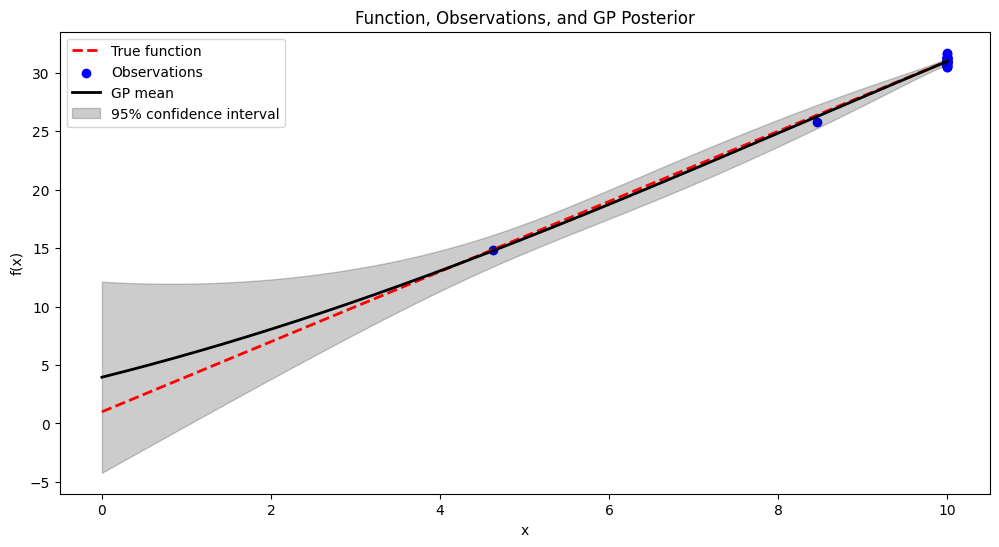

In [41]:
x_range = np.linspace(gpucb_env.xmin, gpucb_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpucb_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpucb_env.xhist, gpucb_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

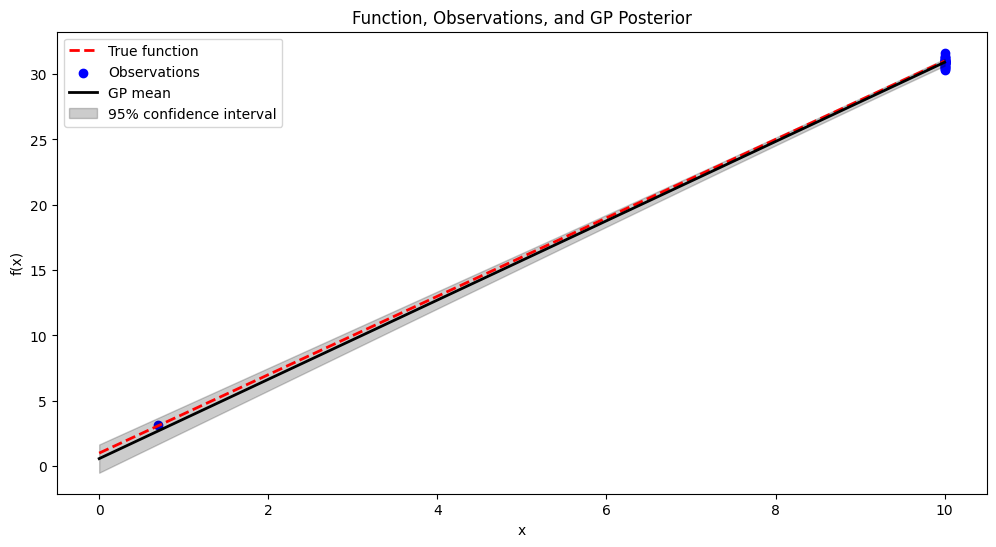

In [42]:
x_range = np.linspace(gpts_env.xmin, gpts_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpts_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpts_env.xhist, gpts_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

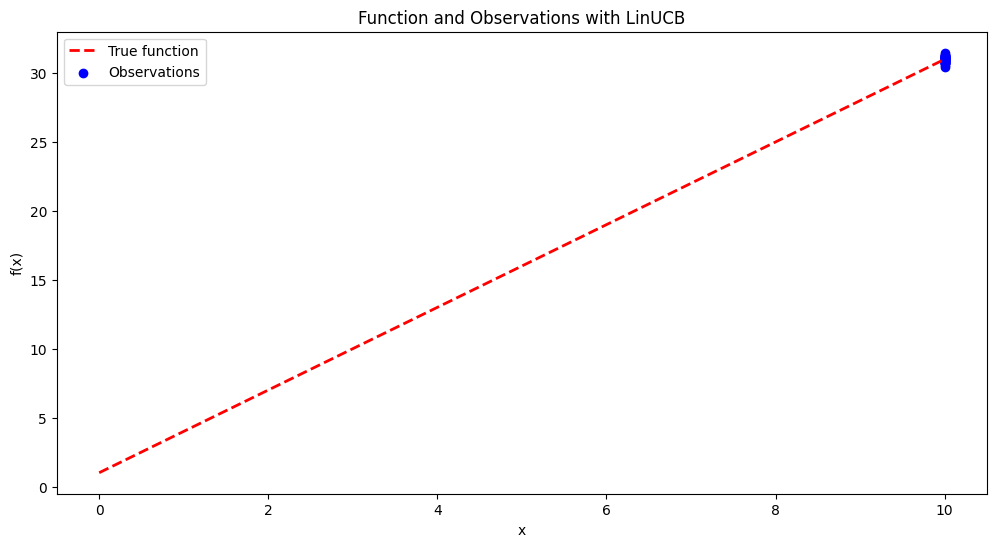

In [43]:
x_range = np.linspace(lin_env.xmin, lin_env.xmax, 1000)
y_true = np.array([linear_function(xi) for xi in x_range])

# Since LinUCB doesn't provide mean and standard deviation of predictions, we will just plot the true values and observations
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(lin_env.xhist, lin_env.yhist, c='b', label='Observations')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function and Observations with LinUCB')
plt.legend()
plt.show()


In [44]:
gpucb_regs = []
gpts_regs = []
linucb_regs = []
for _ in tqdm(range(10)):
    gpucb_reg, gpucb_model, gpucb_env = run_gpucb(sinusoidal_function)
    gpucb_regs.append(np.cumsum(gpucb_reg))
    gpts_reg, gpts_model, gpts_env = run_gpts(sinusoidal_function, "sinus")
    gpts_regs.append(np.cumsum(gpts_reg))
    linucb_reg, lin_model, lin_env = run_linucb(sinusoidal_function)
    linucb_regs.append(linucb_reg)

100%|██████████| 10/10 [02:54<00:00, 17.44s/it]


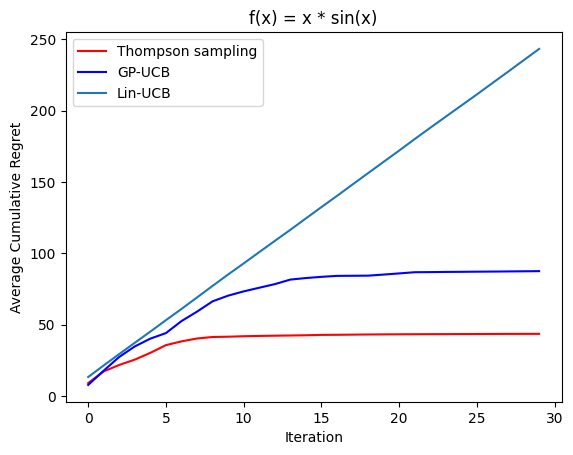

In [45]:
plt.plot(np.mean(gpts_regs, axis=0), label = 'Thompson sampling',color = 'r')
plt.plot(np.mean(gpucb_regs, axis=0), label = 'GP-UCB',color = 'b')
plt.plot(np.mean(linucb_regs, axis=0), label = 'Lin-UCB')
plt.xlabel('Iteration')
plt.ylabel('Average Cumulative Regret')
plt.title('f(x) = x * sin(x)')
plt.legend()
plt.show()

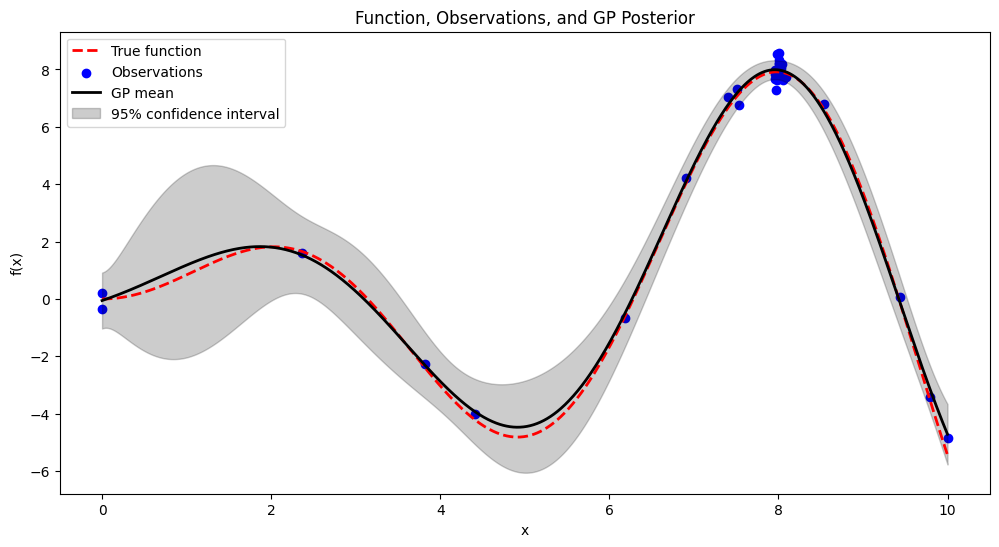

In [46]:
x_range = np.linspace(gpucb_env.xmin, gpucb_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpucb_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpucb_env.xhist, gpucb_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

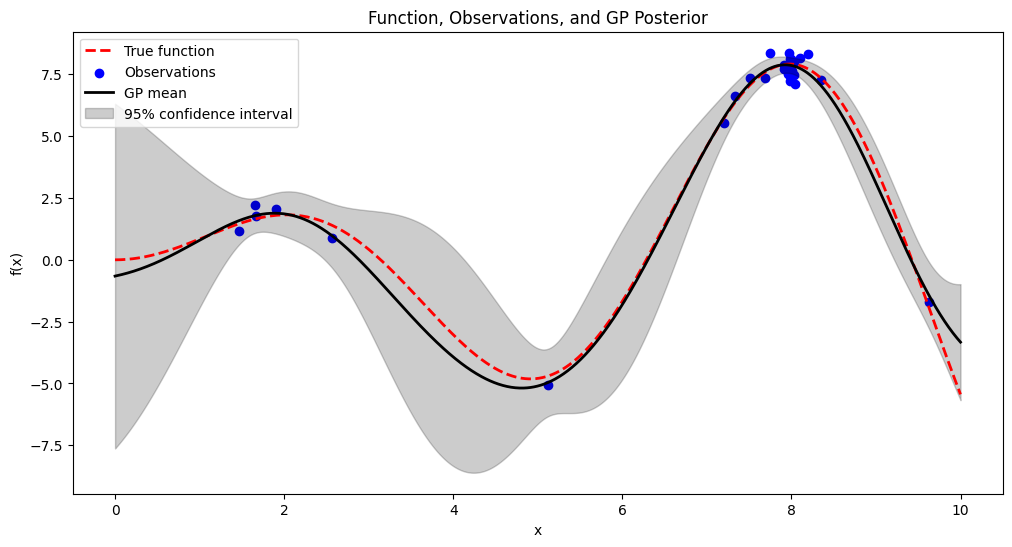

In [47]:
x_range = np.linspace(gpts_env.xmin, gpts_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpts_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpts_env.xhist, gpts_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

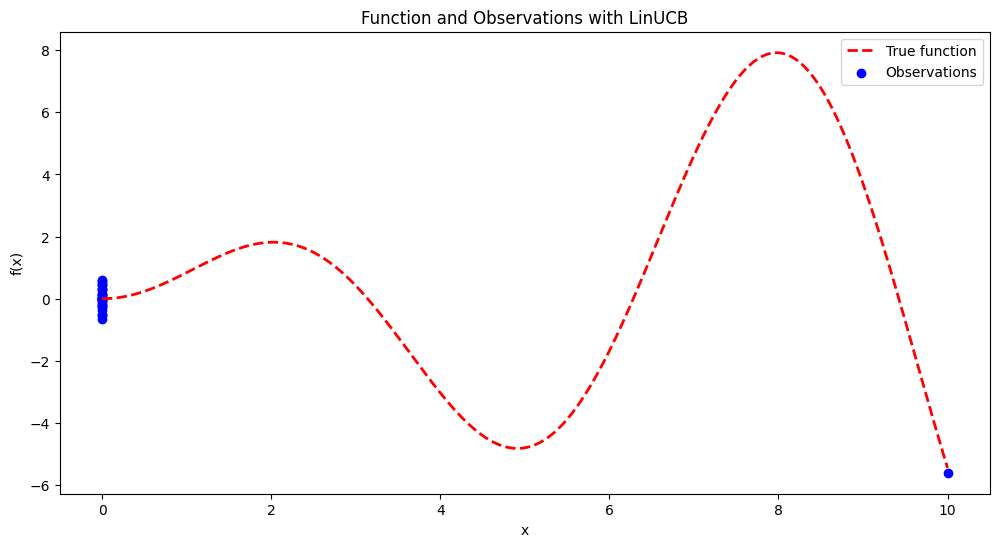

In [48]:
x_range = np.linspace(lin_env.xmin, lin_env.xmax, 1000)
y_true = np.array([sinusoidal_function(xi) for xi in x_range])

# Since LinUCB doesn't provide mean and standard deviation of predictions, we will just plot the true values and observations
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(lin_env.xhist, lin_env.yhist, c='b', label='Observations')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function and Observations with LinUCB')
plt.legend()
plt.show()


In [49]:
gpucb_regs = []
gpts_regs = []
linucb_regs = []
for _ in tqdm(range(10)):
    gpucb_reg, gpucb_model, gpucb_env = run_gpucb(qudratic_function)
    gpucb_regs.append(np.cumsum(gpucb_reg))
    gpts_reg, gpts_model, gpts_env = run_gpts(qudratic_function, "poly")
    gpts_regs.append(np.cumsum(gpts_reg))
    linucb_reg, lin_model, lin_env = run_linucb(qudratic_function)
    linucb_regs.append(linucb_reg)

100%|██████████| 10/10 [03:09<00:00, 18.93s/it]


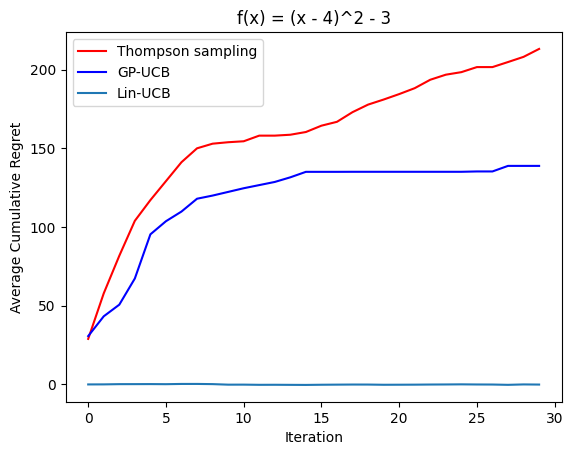

In [50]:
plt.plot(np.mean(gpts_regs, axis=0), label = 'Thompson sampling',color = 'r')
plt.plot(np.mean(gpucb_regs, axis=0), label = 'GP-UCB',color = 'b')
plt.plot(np.mean(linucb_regs, axis=0), label = 'Lin-UCB')
plt.xlabel('Iteration')
plt.ylabel('Average Cumulative Regret')
plt.title('f(x) = (x - 4)^2 - 3')
plt.legend()
plt.show()

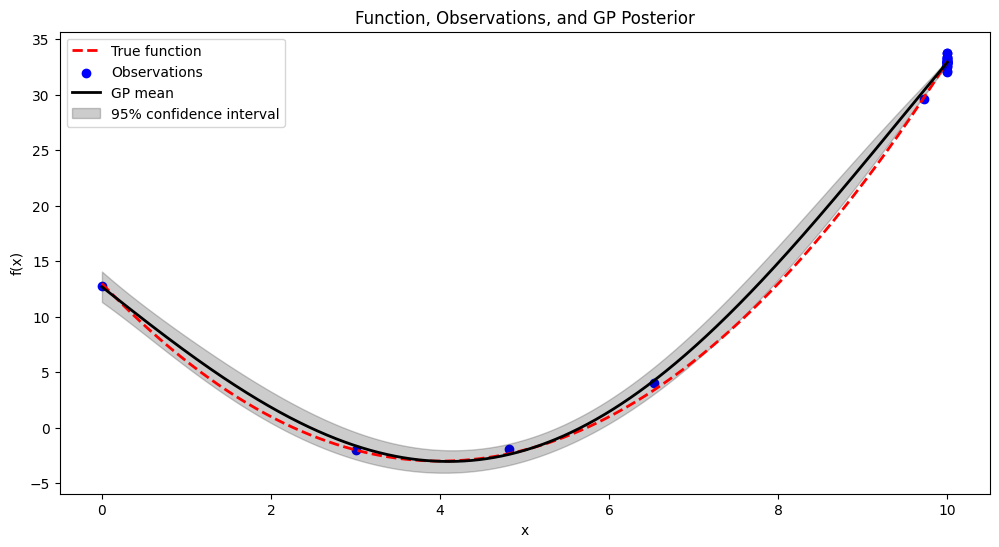

In [51]:
x_range = np.linspace(gpucb_env.xmin, gpucb_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpucb_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpucb_env.xhist, gpucb_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

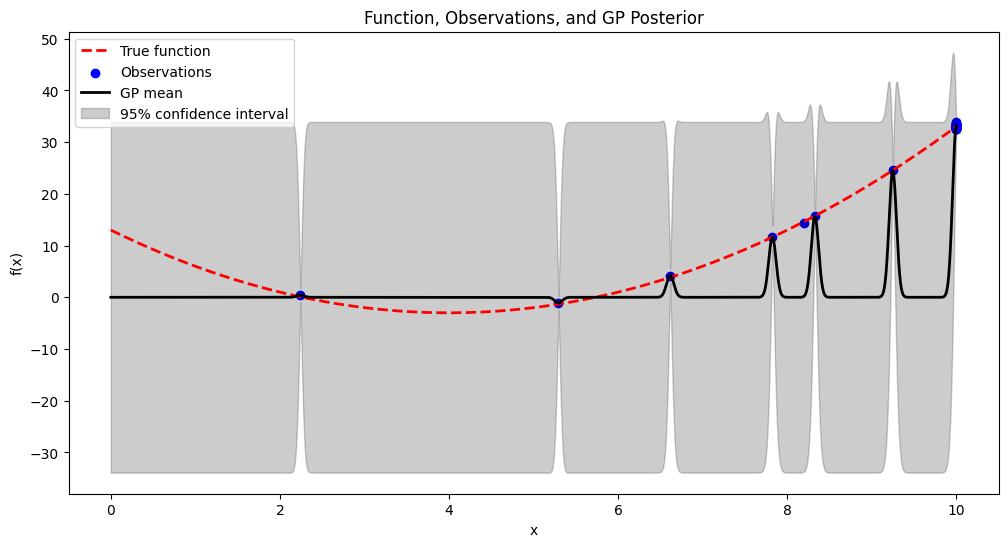

In [52]:
x_range = np.linspace(gpts_env.xmin, gpts_env.xmax, 1000)
y_true = np.array([gpucb_env.f(xi) for xi in x_range])
mu, sigma = gpts_model.gp.predict(x_range.reshape(-1, 1), return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(gpts_env.xhist, gpts_env.yhist, c='b', label='Observations')
plt.plot(x_range, mu, 'k-', lw=2, label='GP mean')
plt.fill_between(x_range, mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function, Observations, and GP Posterior')
plt.legend()
plt.show()

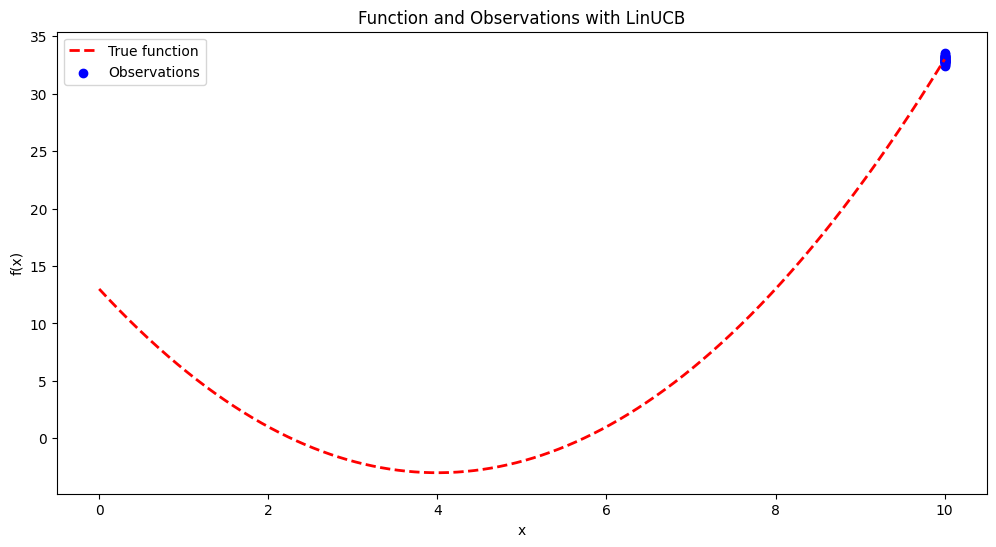

In [53]:
x_range = np.linspace(lin_env.xmin, lin_env.xmax, 1000)
y_true = np.array([qudratic_function(xi) for xi in x_range])

# Since LinUCB doesn't provide mean and standard deviation of predictions, we will just plot the true values and observations
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_true, 'r--', lw=2, label='True function')
plt.scatter(lin_env.xhist, lin_env.yhist, c='b', label='Observations')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function and Observations with LinUCB')
plt.legend()
plt.show()
